## Preparations

### Branch: XAI_tool

### Running Jupyter Notebook
1. In OpenPCDet, got to `docker\run.sh`.
2. Add the following line `-p 5000:8888` after the line `-it \` in the file.
3. This maps port 8888 in the docker to port 5000 in the host.
4. Install jupyter in the docker.
5. To use jupyter notebook: `jupyter notebook --ip 0.0.0.0 --no-browser --allow-root`
6. Then type `localhost:5000/tree` in your browser

### Preparing Captum
1. The visualization script in Captum was modified to group positive/negative gradients.
2. Hence don't just install Captum directly and use it, but do the following instead:
3. `cd pcdet/captum`
4. `pip install -e .`

### Functionalities
1. Given a certain lidar frame, identify all predictions as TP/FP
2. List out anchor box id for all predictions as well as predicted scores for each class
3. Generate box-wise explanations given anchor box id and class id

### TODO
1. Identify anchors matching FN boxes and show explanations

## XAI Related Imports (in Docker only)

In [1]:
# %matplotlib inline

import os
import copy
import torch
from tensorboardX import SummaryWriter
import time
import glob
import re
import h5py
import datetime
import argparse
import csv
import math
from pathlib import Path
import torch.distributed as dist
from pcdet.datasets import build_dataloader
from pcdet.models import build_network
from pcdet.utils import common_utils
from pcdet.config import cfg, cfg_from_list, cfg_from_yaml_file, log_config_to_file
from pcdet.datasets.kitti.kitti_bev_visualizer import KITTI_BEV
from pcdet.datasets.cadc.cadc_bev_visualizer import CADC_BEV
from pcdet.utils import box_utils
from eval_utils import eval_utils
from XAI_utils.bbox_utils import *
from XAI_utils.tp_fp import *
from XAI_utils.XQ_utils import *
from pcdet.models import load_data_to_gpu
from pcdet.datasets.kitti.kitti_dataset import KittiDataset
from pcdet.datasets.cadc.cadc_dataset import CadcDataset
from pcdet.datasets.kitti.kitti_object_eval_python.eval import d3_box_overlap

# XAI related imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torchvision import models

from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

from XAI import *

CudaAPIError: [999] Call to cuDevicePrimaryCtxRetain results in CUDA_ERROR_UNKNOWN

## 2D Explanations (in Docker only)

### Indicating Dataset, Model, Explanation Method, Model Checkpoint

In [2]:
'''________________________User Input Begin________________________'''
dataset_name = 'KittiDataset' # change to your dataset, follow naming convention in the config yaml files in PCDet
method = 'IG'                 # explanation method
attr_shown = 'positive'       # show positive or negative attributions

# IG specific parameters
mult_by_inputs = True         # whether to show attributions only at where some input exists
steps = 24                    # number of intermediate steps for IG

# config file for the full PointPillars model
cfg_file = 'cfgs/kitti_models/pointpillar_xai.yaml' 
# config file for the truncated PointPillars model: 2D backbone and SSD
explained_cfg_file = 'cfgs/kitti_models/pointpillar_2DBackbone_DetHead_xai.yaml' 


# model checkpoint, change to your checkpoint, make sure it's a well-trained model
ckpt = '../output/kitti_models/pointpillar/default/ckpt/pointpillar_7728.pth'

'''________________________User Input End________________________'''

# creating config objects for the PointPillars and the truncated PointPillars model
x_cfg = copy.deepcopy(cfg)
cfg_from_yaml_file(cfg_file, cfg)
cfg.TAG = Path(cfg_file).stem
cfg.EXP_GROUP_PATH = '/'.join(cfg_file.split('/')[1:-1])
cfg_from_yaml_file(explained_cfg_file, x_cfg)

# create output directories, not very useful, just to be compatible with PCDet's structures
output_dir = cfg.ROOT_DIR / 'output' / cfg.EXP_GROUP_PATH / cfg.TAG / 'default'
output_dir.mkdir(parents=True, exist_ok=True)
eval_output_dir = output_dir / 'eval'

eval_all = False
eval_tag = 'default'

if not eval_all:
    num_list = re.findall(r'\d+', ckpt) if ckpt is not None else []
    epoch_id = num_list[-1] if num_list.__len__() > 0 else 'no_number'
    eval_output_dir = eval_output_dir / ('epoch_%s' % epoch_id) / cfg.DATA_CONFIG.DATA_SPLIT['test']
else:
    eval_output_dir = eval_output_dir / 'eval_all_default'

if eval_tag is not None:
    eval_output_dir = eval_output_dir / eval_tag

eval_output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# create logger, not very useful, just to be compatible with PCDet's structures
log_file = eval_output_dir / ('log_eval_%s.txt' % datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
logger = common_utils.create_logger(log_file, rank=cfg.LOCAL_RANK)

# log to file
logger.info('**********************Start logging**********************')

2021-05-06 01:23:48,993   INFO  **********************Start logging**********************


In [4]:
# arguments for dataloader
class_name_list = cfg.CLASS_NAMES
batch_size = 1
workers = 4
dist_test = False

# visualization parameters, don't change unless you really need to modify the visualizations
high_rez = True
scaling_factor = 5.0
color_map = 'gist_yarg'
dpi_division_factor = 20.0
box_margin_list = [0.2, 0.5, 1, 1.5, 2, 3, 5]
box_margin = 0.5
overlay = 0.4
figure_size = (32, 24)
plot_enlarged_pred = True

# data set prepration, use the validation set (called 'test_set' here)
test_set, test_loader, sampler = build_dataloader(
        dataset_cfg=cfg.DATA_CONFIG,
        class_names=cfg.CLASS_NAMES,
        batch_size=batch_size,
        dist=dist_test, workers=workers, logger=logger, training=False
    )

2021-05-06 01:23:49,002   INFO  Loading KITTI dataset
2021-05-06 01:23:49,119   INFO  Total samples for KITTI dataset: 3769


In [5]:
# define iou thresholds
tight_iou = False
d3_iou_thresh_dict = {}
if dataset_name == 'KittiDataset':
    if tight_iou:
        d3_iou_thresh = [0.7, 0.5, 0.5]
        d3_iou_thresh_dict = {'Car': 0.7, 'Pedestrian': 0.5, 'Cyclist': 0.5}
    else:
        d3_iou_thresh = [0.5, 0.25, 0.25]
        d3_iou_thresh_dict = {'Car': 0.5, 'Pedestrian': 0.25, 'Cyclist': 0.25}
elif dataset_name == 'CadcDataset':
    if tight_iou:
        d3_iou_thresh = [0.7, 0.5, 0.7]
        d3_iou_thresh_dict = {'Car': 0.7, 'Pedestrian': 0.5, 'Truck': 0.7}
    else:
        d3_iou_thresh = [0.5, 0.25, 0.5]
        d3_iou_thresh_dict = {'Car': 0.5, 'Pedestrian': 0.25, 'Truck': 0.5}

In [6]:
# build the models and the explainers

# the full PointPillars model
model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=test_set)
model.load_params_from_file(filename=ckpt, logger=logger, to_cpu=dist_test)
model.cuda()
model.eval()

# the partial PointPillars model
model2D = model.forward_model2D

# explainer 
explainer = None

# build the IG explainer
ig2D = IntegratedGradients(model2D, multiply_by_inputs=mult_by_inputs)

if method == "IG":
    explainer = ig2D


 data type of num_filters in PillarVFE: <class 'list'>

 length of num_filters: 2

 num_filters[0]: 10

 num_filters[1]: 64


2021-05-06 01:23:51,094   INFO  ==> Loading parameters from checkpoint ../output/kitti_models/pointpillar/default/ckpt/pointpillar_7728.pth to GPU
2021-05-06 01:23:51,188   INFO  ==> Done (loaded 127/127)


In [7]:
# initialize the visulizer, need to change if you are using a different dataset
bev_visualizer = KITTI_BEV(dataset=test_set, scale_to_pseudoimg=(not high_rez), class_name=class_name_list,
                          background='black',
                          result_path='output/kitti_models/pointpillar/default/eval/epoch_7728/val/default/result.pkl',
                          scale=scaling_factor, cmap=color_map, dpi_factor=dpi_division_factor,
                          margin_list=box_margin_list)
if dataset_name == "CadcDataset":
    bev_visualizer = CADC_BEV(dataset=test_set, scale_to_pseudoimg=(not high_rez), class_name=class_name_list,
                        background='black',
                        scale=scaling_factor, cmap=color_map, dpi_factor=dpi_division_factor, margin=box_margin)

self.margins: [0.2, 0.5, 1, 1.5, 2, 3, 5]


### Indicate the Specific Sample to be Explained and Get Explanations

In [14]:
# get gt info
gt_infos = get_gt_infos(cfg, test_set)

In [15]:
'''________________________User Input Begin________________________'''
# since batch_size = 1, the 56th batch is exactly the 56th frame in the validation set
# for KITTI, specify a value in the range 0 to 3768
val_batch_index = 358
'''________________________User Input End________________________'''

gt_dict = gt_infos[val_batch_index]

In [16]:
# run the forward pass once to generate outputs and intermediate representations
batch_dict = {}
for batch_num, batch_dictionary in enumerate(test_loader):
    if batch_num == val_batch_index:
        batch_dict = batch_dictionary
        break
dummy_tensor = 0  # necessary for the XAI operations
load_data_to_gpu(batch_dict)
anchors_scores = None
with torch.no_grad():
    anchors_scores = model(dummy_tensor, batch_dict)
pred_dicts = batch_dict['pred_dicts']
pred_boxes = pred_dicts[0]['pred_boxes'].cpu().numpy()
pred_labels = pred_dicts[0]['pred_labels'].cpu().numpy() - 1
pred_scores = pred_dicts[0]['pred_scores'].cpu().numpy()

# obtain the Pseudoimage
PseudoImage2D = batch_dict['spatial_features']

# run the visualizer to get BEV of the original lidar point cloud with predictions and gt boxes labelled
bev_visualizer.set_pred_box(pred_boxes, pred_labels)
pred_boxes_for_pts = bev_visualizer.pred_boxes_for_cnt
bev_fig, bev_fig_data = bev_visualizer.get_bev_image(val_batch_index)
pred_boxes_vertices = bev_visualizer.pred_poly
padded_pred_boxes_vertices = bev_visualizer.pred_poly_expand
gt_boxes_vertices = bev_visualizer.gt_poly
gt_boxes_loc = bev_visualizer.gt_loc
pred_boxes_loc = bev_visualizer.pred_loc


result_frame.keys(): dict_keys(['name', 'truncated', 'occluded', 'alpha', 'bbox', 'dimensions', 'location', 'rotation_y', 'score', 'boxes_lidar', 'frame_id'])

val sample_idx: 000002

number of gt boxes according to the get_label method of the dataset object: 1

Processing Sample: 000002
len(self.pred_poly_expand): 7


In [19]:
# compute iou for the predictions
iou, gt_index, overlaps = calculate_iou(gt_dict['boxes'], pred_boxes, dataset_name, ret_overlap=True)
        
# generate TP/FP information about the predictions

conf_mat_frame = []
box_debug = False
score_thresh = 0.1

for j in range(len(pred_scores)):  # j is prediction box id in the i-th image
    gt_cls = gt_dict['labels'][gt_index[j]]
    iou_thresh_3d = d3_iou_thresh_dict[gt_cls]
    curr_pred_score = pred_scores[j]
    if curr_pred_score >= score_thresh:
        adjusted_pred_boxes_label = pred_labels[j]
        pred_name = class_name_list[adjusted_pred_boxes_label]
        if iou[j] >= iou_thresh_3d:
            if gt_cls == pred_name:
                conf_mat_frame.append('TP')
            else:
                conf_mat_frame.append('FP')
            if box_debug:
                print("pred_box_ind: {}, pred_label: {}, gt_ind is {}, gt_label: {}, iou: {}".format(
                    j, pred_name, gt_index[j], gt_cls, iou[j]))
        elif iou[j] > 0:
            conf_mat_frame.append('FP')
            if box_debug:
                print("pred_box_ind: {}, pred_label: {}, gt_ind is {}, gt_label: {}, iou: {}".format(
                    j, pred_name, gt_index[j], gt_cls, iou[j]))
        else:
            conf_mat_frame.append('FP')
            if box_debug:
                print("pred_box_ind: {}, pred_label: {}, didn't match any gt boxes".format(j, pred_name))
    else:
        conf_mat_frame.append('ignore')  # these boxes do not meet score thresh, ignore for now
        print("pred_box {} has score below threshold: {}".format(j, curr_pred_score))

In [20]:
# need to horizontally flip the original bev image and rotate 90 degrees ccw to match location of explanations
bev_image_raw = np.flip(bev_fig_data, 0)
bev_image = np.rot90(bev_image_raw, k=1, axes=(0, 1))

# obtain anchor box ids corresponding to the predictions
anchor_select = batch_dict['anchor_selections'][0]
anchor_scores = batch_dict['sigmoid_anchor_scores'][0]

# print out the prediction labels and anchor indices
print("pred_box_id  anchor_box_id  pred_label TP/FP top_score{0: ^12}{1: ^12}{2: ^12}".format(
    class_name_list[0], class_name_list[1], class_name_list[2]))
for i in range(len(anchor_select)):
    anchor_id = anchor_select[i]
    print("{0: ^12}{1: ^14}{2: ^14}{3: ^４}{4: ^10.4f}{5: ^12.4f}{6: ^12.4f}{7: ^12.4f}".format(
        i, anchor_id, class_name_list[pred_labels[i]],conf_mat_frame[i], pred_scores[i], 
        anchor_scores[anchor_id][0],anchor_scores[anchor_id][1], anchor_scores[anchor_id][2]))

pred_box_id  anchor_box_id  pred_label TP/FP top_score    Car      Pedestrian   Cyclist   
     0          148386         Car       FP   0.8493     0.8493      0.0002      0.0002   
     1          175258       Cyclist     FP   0.3560     0.0002      0.0002      0.3560   
     2          174111      Pedestrian   FP   0.2898     0.0001      0.2898      0.0001   
     3          176380       Cyclist     FP   0.2393     0.0002      0.0002      0.2393   
     4          149186      Pedestrian   FP   0.1933     0.0001      0.1933      0.0001   
     5          166722         Car       FP   0.1658     0.1658      0.0001      0.0001   
     6          143162      Pedestrian   FP   0.1657     0.0001      0.1657      0.0001   
     7          176457      Pedestrian   FP   0.1604     0.0001      0.1604      0.0001   
     8          146594      Pedestrian   FP   0.1537     0.0001      0.1537      0.0001   
     9          176529      Pedestrian   FP   0.1453     0.0000      0.1453      0.0000   

In [ ]:
'''________________________User Input Begin________________________'''
pred_id = 2                # corresponding predicted box id, only applicable in the case of TP/FP explanations
anchor_id = anchor_select[pred_id]    # select the anchor box you want to explain
class_id = 0               # dataset dependent, e.g., 2 means cyclist for KITTI
'''________________________User Input End________________________'''

# assign target and get attributions
target = (anchor_id, class_id)
attributions = explainer.attribute(PseudoImage2D, baselines=PseudoImage2D * 0, target=target,
                                   additional_forward_args=batch_dict, n_steps=steps,
                                   internal_batch_size=batch_dict['batch_size'])

# separating the positive and negative gradients

# transform the attributions to match lidar bev orientation
grad = np.transpose(attributions[0].squeeze().cpu().detach().numpy(), (1, 2, 0))
pos_grad = np.sum((grad > 0) * grad, axis=2)
neg_grad = np.sum(-1 * (grad < 0) * grad, axis=2)
pos_grad_copy = copy.deepcopy(pos_grad)
neg_grad_copy = copy.deepcopy(neg_grad)

### Note about visualization

Green boxes: ground truth boxes

Red boxes: predicted boxes

Yellow box: predicted box currently being explained

Green shades: positive attributions

Red shades: negative attributions

In [15]:
# generating the box that surrounds the predicted box being explained
H, W = grad.shape[0], grad.shape[1]  # image height and width
box_vertices = padded_pred_boxes_vertices[0][pred_id]
box_vertices = transform_box_coord(H, W, box_vertices, dataset_name, high_rez, scaling_factor)
box_explained = flip_xy(box_vertices)

/root/pcdet/captum/captum/attr/_utils/visualization.py:370: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt_fig.tight_layout(pad=0)


box_explained: [[1734.34768989 1489.53565154]
 [1595.14195936 1481.95751406]
 [1591.67660401 1545.61396327]
 [1730.88233454 1553.19210075]]


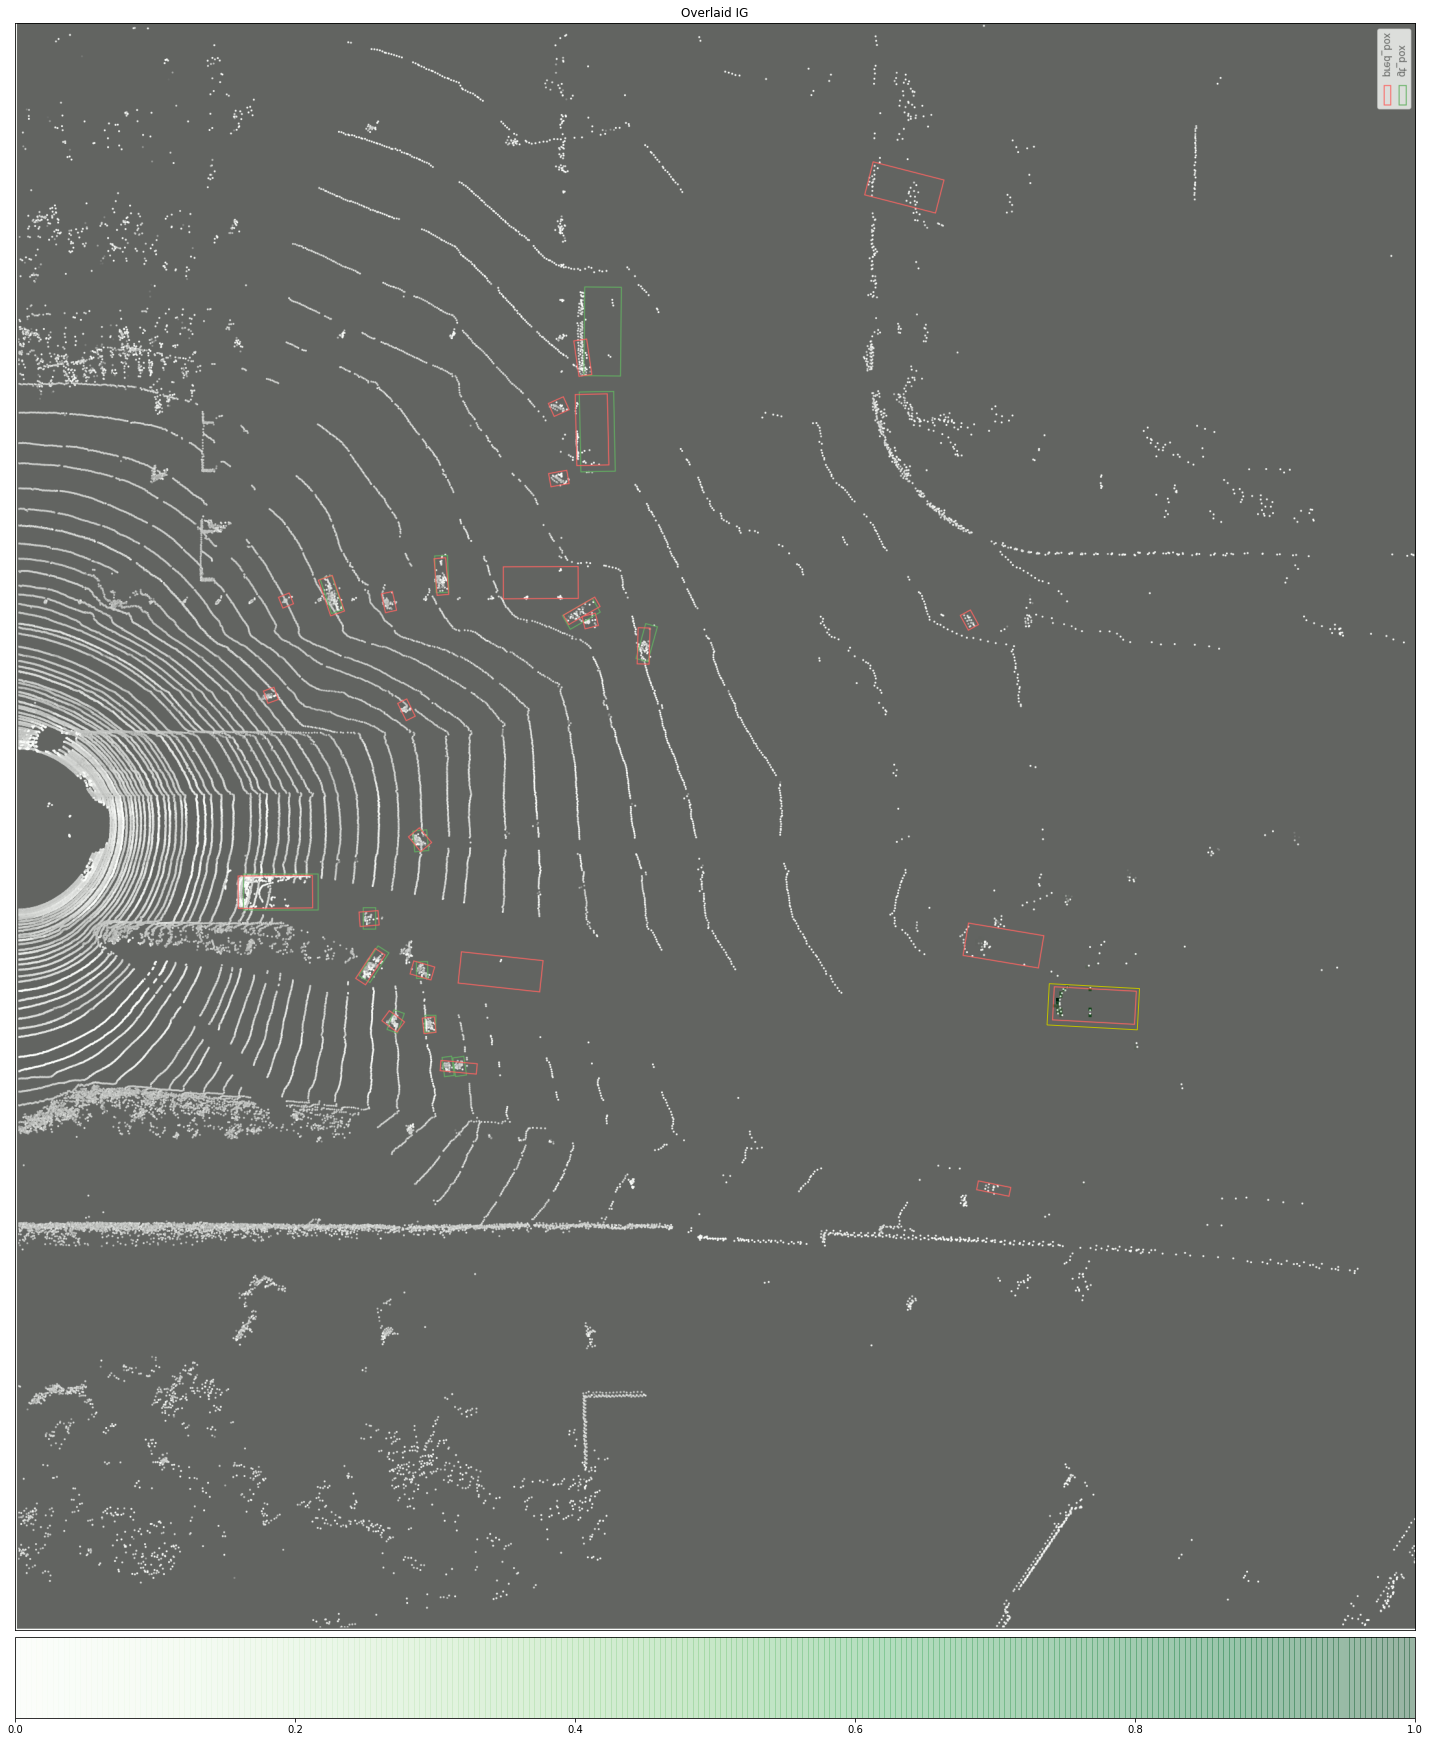

In [16]:
# generate visualization: pseudoimage attribution overlaid on top of lidar bev
grad_viz = viz.visualize_image_attr(grad, bev_image, method="blended_heat_map", sign=attr_shown, show_colorbar=True,
                                    title="Overlaid {}".format(method), alpha_overlay=overlay,
                                    fig_size=figure_size, upscale=high_rez, use_pyplot=False)

# add the indicator box
if plot_enlarged_pred:
    polys = patches.Polygon(box_explained, closed=True, fill=False, edgecolor='y', linewidth=1)
    grad_viz[1].add_patch(polys)
    print('box_explained: {}'.format(box_explained))

# show the attribution map with the indicator box overlaid
grad_viz[1].figure

## LiDAR Frame and 2D Image Visualization (can run locally)

In [1]:
import pickle
import numpy as np
import pandas as pd
import open3d as o3d
from pathlib import Path

import matplotlib.pyplot as plt


import visualiser_hn as vis

import importlib



In [2]:
file_name = '../data/kitti/kitti_infos_trainval.pkl' #Change your own part
with open(file_name, 'rb') as f:
    infos = pickle.load(f)
    
print("Data length: ", len(infos))

Data length:  7481


In [3]:
infos[3]

{'point_cloud': {'num_features': 4, 'lidar_idx': '000009'},
 'image': {'image_idx': '000009',
  'image_shape': array([ 375, 1242], dtype=int32)},
 'calib': {'P2': array([[7.21537720e+02, 0.00000000e+00, 6.09559326e+02, 4.48572807e+01],
         [0.00000000e+00, 7.21537720e+02, 1.72854004e+02, 2.16379106e-01],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 2.74588400e-03],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'R0_rect': array([[ 0.9999239 ,  0.00983776, -0.00744505,  0.        ],
         [-0.0098698 ,  0.9999421 , -0.00427846,  0.        ],
         [ 0.00740253,  0.00435161,  0.9999631 ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  1.        ]],
        dtype=float32),
  'Tr_velo_to_cam': array([[ 7.53374491e-03, -9.99971390e-01, -6.16602018e-04,
          -4.06976603e-03],
         [ 1.48024904e-02,  7.28073297e-04, -9.99890208e-01,
          -7.63161778e-02],
         [ 9.99862075e-01,  7.52379000e-03,  1.480755

In [4]:
root_split_path = Path('../data/kitti/training') #Change your own part

def get_lidar(idx):
    lidar_file = root_split_path / 'velodyne' / ('%s.bin' % idx)
    print(lidar_file)
    assert lidar_file.exists()
    return np.fromfile(str(lidar_file), dtype=np.float32).reshape(-1, 4)

from skimage import io

def get_image(idx):
    img_file = root_split_path / 'image_2' / ('%s.png' % idx)
    assert img_file.exists()
    return np.array(io.imread(img_file))


def search_sample(idx,infos):
    for i,info in enumerate(infos):
        if info['point_cloud']['lidar_idx'] == idx:
            return i
    print("no sample exist")
    print(idx)
    return None


In [5]:
def get_frame_id(batch_index, frame_id_file):
    index_mapping = pd.read_csv(frame_id_file)
    frame_indices = index_mapping['orig_frame_id']
    frame_id = frame_indices[batch_index]
    return str(frame_id).zfill(6)

In [6]:
val_batch_index = 358                # change to the frame you are interested in
frame_id_file = 'val_frame_idx.csv'  # change to your own

frame_id = get_frame_id(val_batch_index, frame_id_file)
print(frame_id)

000727


000727
../data/kitti/training/velodyne/000727.bin


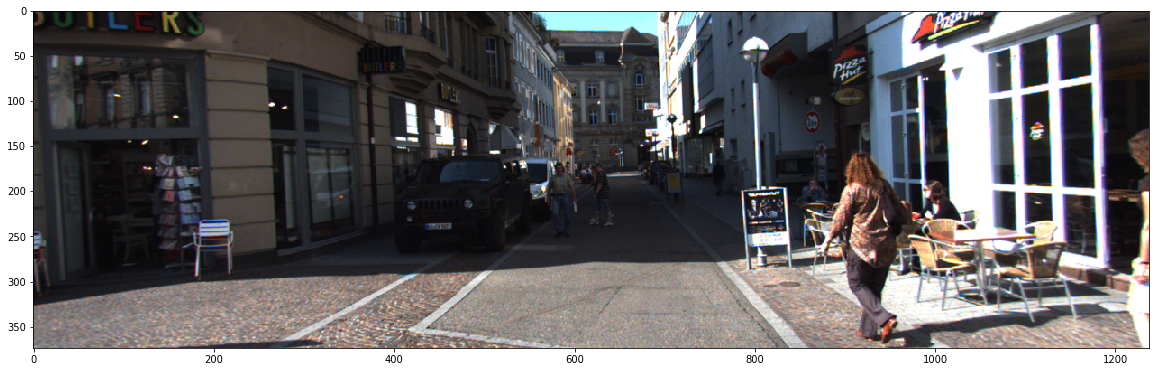

(8, 7)


In [7]:
sample_index = frame_id

info_index = search_sample(sample_index,infos)

info = infos[info_index]

lidar_idx = info['point_cloud']['lidar_idx']
print(lidar_idx)
lidar_points=get_lidar(lidar_idx)

image_idx = info['image']['image_idx']
image = get_image(image_idx)
figure = plt.figure(figsize=(20,10))
plt.imshow(image)
plt.show()


gt_boxes = info['annos']['gt_boxes_lidar']
print(gt_boxes.shape)


vis.vis_points_with_multi_boxes(gt_boxes,lidar_points[:,:3])